# Previsão de Cancelamento de Contas

Esta análise tem como objetivo prever se um cliente irá cancelar sua conta em um banco. Para isso, será utilizado um dataset com informações de clientes de um banco, como saldo, número de produtos, entre outros.

In [1]:
# python imports
import os
import sys
import warnings

from pathlib import Path

warnings.filterwarnings('ignore')
PROJECT_PATH = os.path.abspath('..')
sys.path.append(PROJECT_PATH)

# third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns



from IPython.display import display, Markdown
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


# configurações
pd.options.display.max_columns = 500
default_figsize = (16, 5)
default_figsize_small = (16, 2.5)

dataset_path = Path(PROJECT_PATH) / 'data' / 'Churn_Modelling.csv'

In [2]:
df = pd.read_csv(dataset_path)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Análise Exploratória

### Informações gerais

In [3]:
md = f'''\
__Quantidade de Variáveis__: {df.shape[1]} \\
__Quantidade de Observações__: {df.shape[0]}

__RowNumber__: Um número sequencial atribuído a cada linha. \\
__CustomerId__: Um identificador único para cada cliente. 

As colunas RowNumber e CustomerId não são relevantes para a análise, portanto, serão removidas.
'''

display(Markdown(md))

df.drop(columns=['RowNumber', 'CustomerId'], inplace=True, errors='ignore')

__Quantidade de Variáveis__: 14 \
__Quantidade de Observações__: 10000

__RowNumber__: Um número sequencial atribuído a cada linha. \
__CustomerId__: Um identificador único para cada cliente. 

As colunas RowNumber e CustomerId não são relevantes para a análise, portanto, serão removidas.


### Valores Nulos


In [4]:
df.isnull().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Não há valores nulos no dataset.

### Exited

Variável Alvo. Indica se o cliente deixou o banco ou não (1 para sim, 0 para não).

In [5]:
df['Exited'].value_counts(normalize=True)

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

O dataset possui um grande desbalanceamento para a variável alvo.

### Surname

Sobrenome do cliente. A princípio, pode parecer irrelevante para a previsão de evasão individual, mas pode conter informações culturais ou geográficas que, em conjunto, poderiam influenciar a evasão (por exemplo, famílias maiores tendem a mudar de banco juntas?). É uma variável que precisa ser tratada com cuidado, pois pode introduzir viés indesejado se mal utilizada.

In [6]:
df['Surname'].describe()

count     10000
unique     2932
top       Smith
freq         32
Name: Surname, dtype: object

In [7]:
df_vc = df['Surname'].value_counts()
df_vc[df_vc == 1]

Surname
Burbidge     1
Hargrave     1
Bearce       1
Goforth      1
McDowell     1
            ..
Hull         1
Sturdee      1
Flannagan    1
Dwyer        1
Corby        1
Name: count, Length: 1558, dtype: int64

Menos da metade dos sobrenomes se repetem. Por essa razão essa coluna será eliminada.

In [8]:
df.drop(columns=['Surname'], inplace=True, errors='ignore')

### CreditScore

Pontuação de crédito do cliente. Uma pontuação mais alta geralmente indica menor risco de inadimplência. É um forte candidato a ser um preditor relevante de encerramento de conta, pois clientes com pontuações mais baixas podem enfrentar dificuldades financeiras que os levem a mudar de banco.

In [9]:
df['CreditScore'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

In [10]:
df['CreditScore'].value_counts()

CreditScore
850    233
678     63
655     54
705     53
667     53
      ... 
358      1
412      1
382      1
373      1
419      1
Name: count, Length: 460, dtype: int64

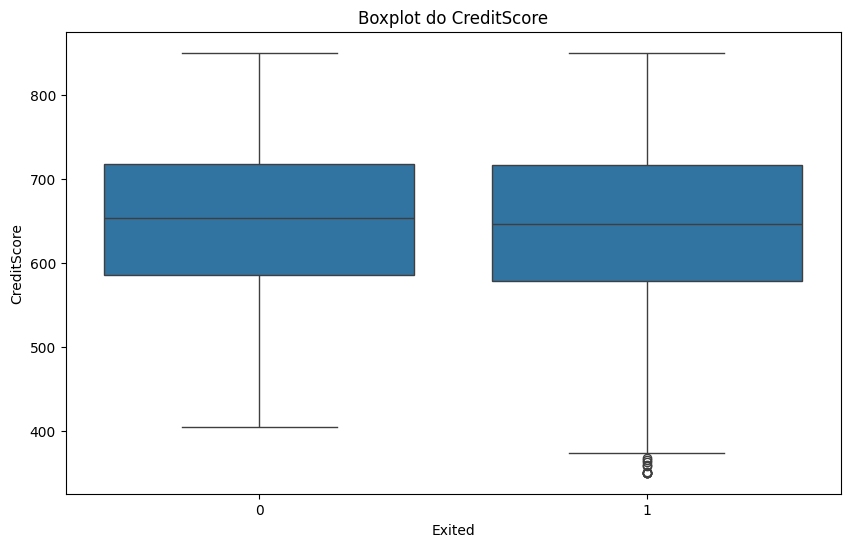

In [11]:
# CreditScore x Exit

plt.figure(figsize=(10,6))
sns.boxplot(y='CreditScore', x='Exited', data=df)
plt.title('Boxplot do CreditScore')
plt.show()

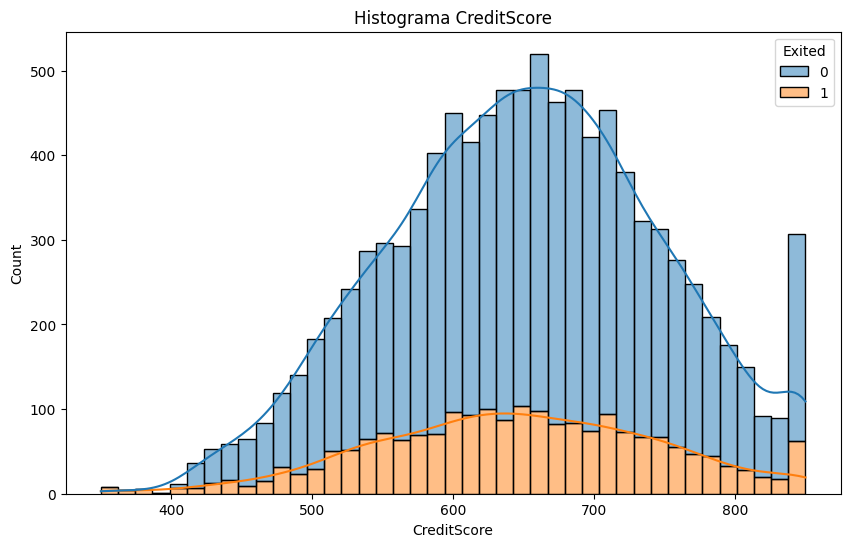

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='CreditScore', hue='Exited', kde=True, multiple='stack')
plt.title('Histograma CreditScore')
plt.show()

### Geography

País de residência do cliente. Provavelmente um preditor importante, pois o comportamento de cancelamento de contas pode variar significativamente entre diferentes regiões devido a fatores econômicos, culturais e até mesmo a concorrência entre bancos em cada país.

In [13]:
df['Geography'].describe()

count      10000
unique         3
top       France
freq        5014
Name: Geography, dtype: object

In [14]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [15]:
df[['Geography','Exited']].groupby(['Geography','Exited']).size().reset_index(name='Total')

,Geography,Exited,Total
0,France,0,4204
1,France,1,810
2,Germany,0,1695
3,Germany,1,814
4,Spain,0,2064
5,Spain,1,413


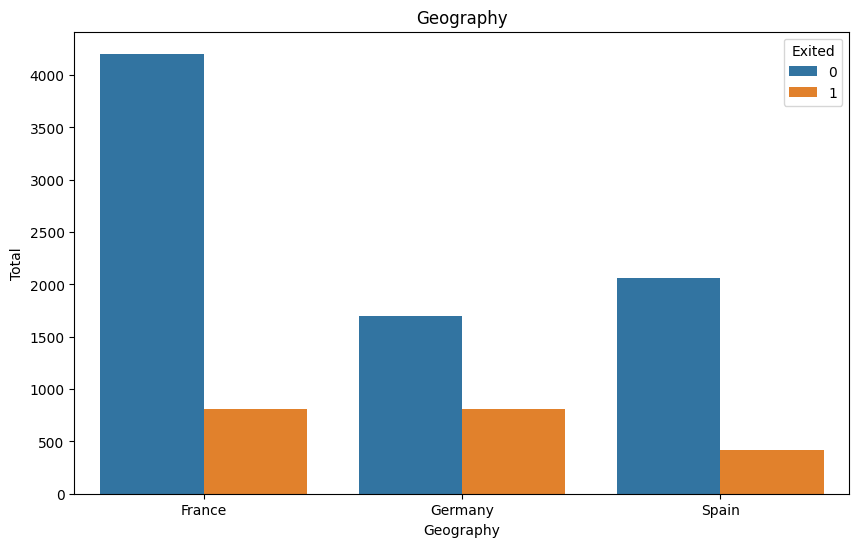

In [16]:
plt.figure(figsize=(10,6))
df_vc = df[['Geography','Exited']].groupby(['Geography','Exited']).size().reset_index(name='Total')
sns.barplot(x='Geography', y='Total', hue='Exited', data=df_vc, orient='v')
plt.title('Geography')
plt.show()

### Gender

Gênero do cliente. Pode haver diferenças comportamentais entre gêneros que influenciam a propensão ao cancelamento de contas, embora seja necessário cautela na interpretação para evitar vieses.

In [17]:
df['Gender'].describe()

count     10000
unique        2
top        Male
freq       5457
Name: Gender, dtype: object

In [18]:
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [19]:
df[['Gender','Exited']].groupby(['Gender','Exited']).size().reset_index(name='Total')

,Gender,Exited,Total
0,Female,0,3404
1,Female,1,1139
2,Male,0,4559
3,Male,1,898


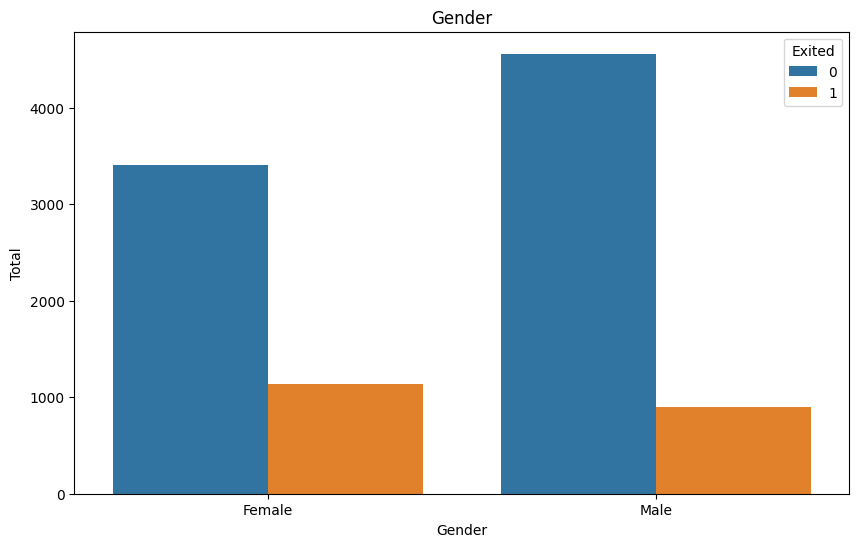

In [20]:
plt.figure(figsize=(10,6))
df_vc = df[['Gender','Exited']].groupby(['Gender','Exited']).size().reset_index(name='Total')
sns.barplot(x='Gender', y='Total', hue='Exited', data=df_vc, orient='v')
plt.title('Gender')
plt.show()

### Age

Idade do cliente. A idade é um fator demográfico crucial. Diferentes faixas etárias podem ter diferentes necessidades bancárias e níveis de lealdade. Por exemplo, clientes mais jovens podem ser mais propensos a mudar para bancos com melhores tecnologias, enquanto clientes mais velhos podem valorizar mais a estabilidade.

In [21]:
df['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

In [22]:
df['Age'].value_counts()

Age
37    478
38    477
35    474
36    456
34    447
     ... 
84      2
82      1
88      1
85      1
83      1
Name: count, Length: 70, dtype: int64

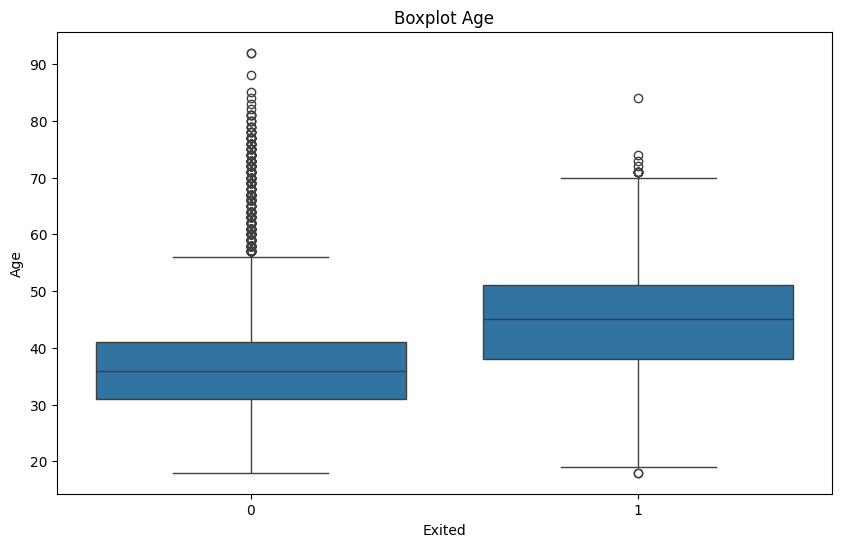

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Age', x='Exited', data=df)
plt.title('Boxplot Age')
plt.show()

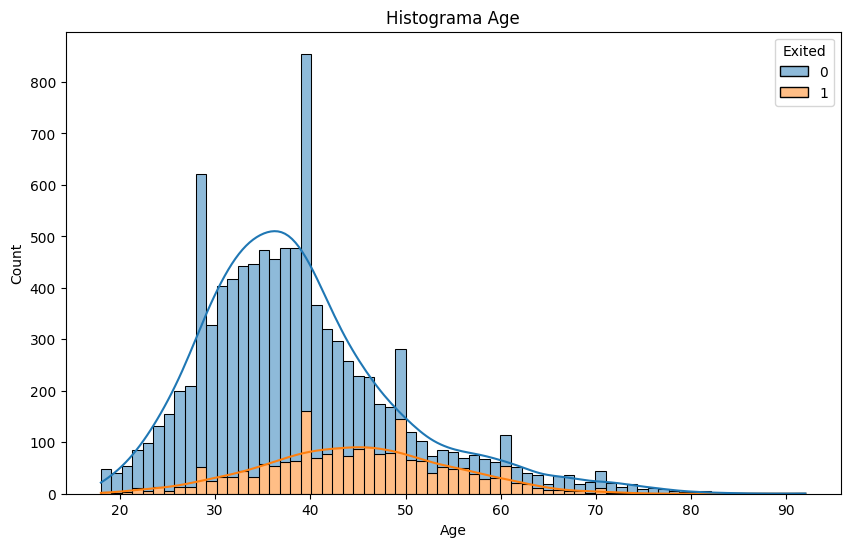

In [24]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Age', hue='Exited', kde=True, multiple='stack')
plt.title('Histograma Age')
plt.show()

### Tenure

Número de anos que o cliente está com o banco. É de se esperar que clientes mais antigos tenham maior lealdade. No entanto, um tempo de relacionamento muito curto também pode indicar insatisfação inicial.

In [25]:
df['Tenure'].describe()

count    10000.000000
mean         5.012800
std          2.892174
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Tenure, dtype: float64

In [26]:
df['Tenure'].value_counts()

Tenure
2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: count, dtype: int64

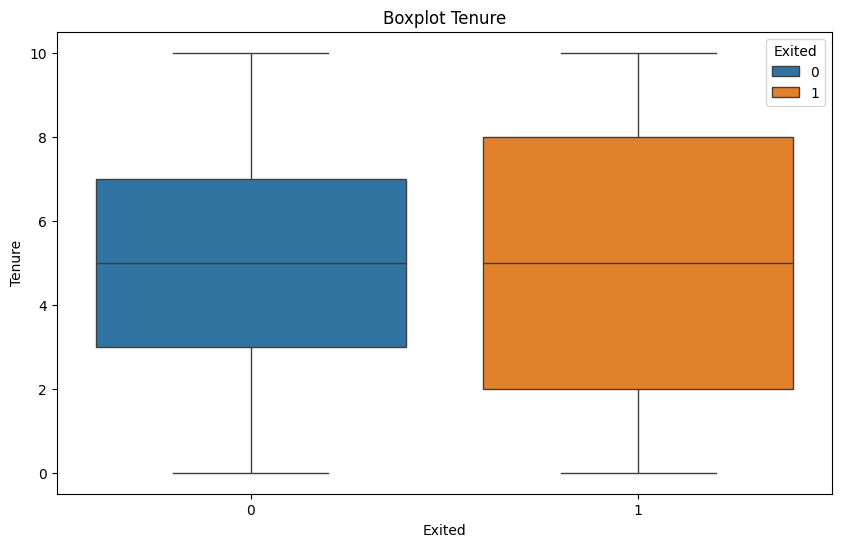

In [27]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Tenure', x='Exited', data=df, hue='Exited')
plt.title('Boxplot Tenure')
plt.show()

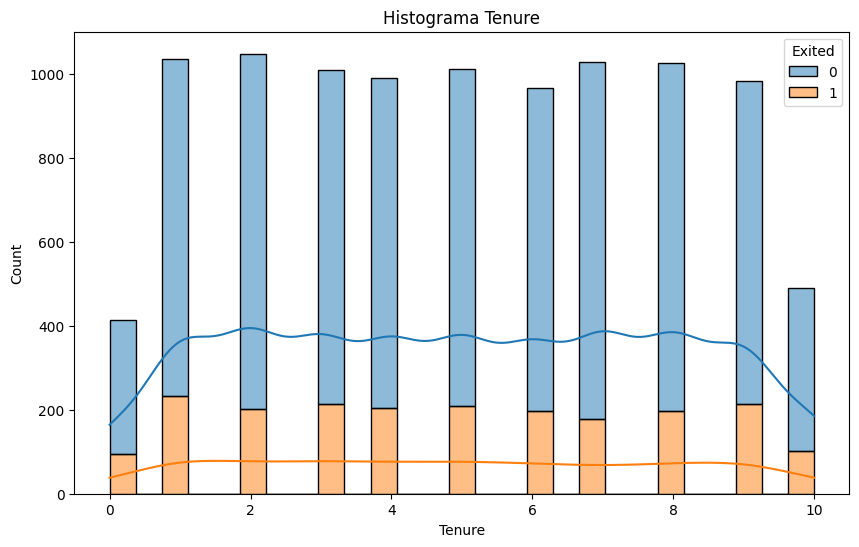

In [28]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Tenure', hue='Exited', kde=True, multiple='stack')
plt.title('Histograma Tenure')
plt.show()

### Balance

Saldo atual na conta do cliente. Clientes com saldos mais altos podem ser mais valiosos para o banco e, portanto, menos propensos a sair. Por outro lado, saldos muito baixos podem indicar inatividade ou insatisfação.

In [29]:
df['Balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

In [30]:
df['Balance'].value_counts()

Balance
0.00         3617
130170.82       2
105473.74       2
113957.01       1
85311.70        1
             ... 
88381.21        1
155060.41       1
57369.61        1
75075.31        1
116363.37       1
Name: count, Length: 6382, dtype: int64

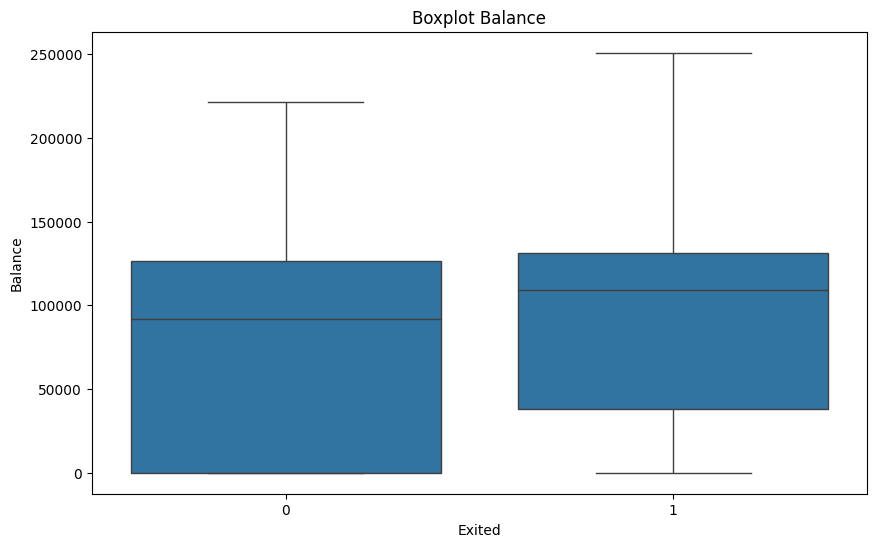

In [31]:
# CreditScore x Exit

plt.figure(figsize=(10,6))
sns.boxplot(y='Balance', x='Exited', data=df)
plt.title('Boxplot Balance')
plt.show()

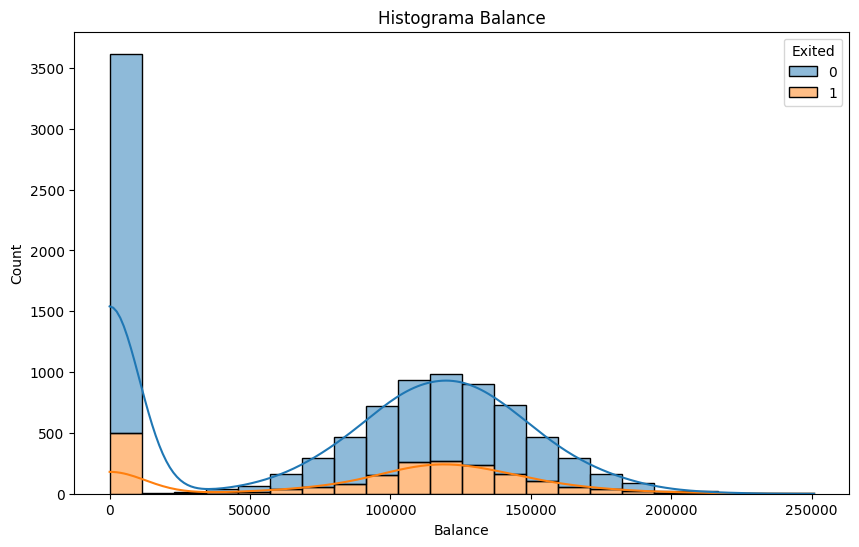

In [32]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Balance', hue='Exited', kde=True, multiple='stack')
plt.title('Histograma Balance')
plt.show()

### NumOfProducts

Número de produtos bancários que o cliente utiliza (por exemplo, conta corrente, poupança, cartão de crédito, empréstimos). Clientes que utilizam mais produtos podem ter maior integração com o banco e, portanto, menor probabilidade de encerramento de conta.


In [33]:
df['NumOfProducts'].describe()

count    10000.000000
mean         1.530200
std          0.581654
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: NumOfProducts, dtype: float64

In [34]:
df['NumOfProducts'].value_counts()

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

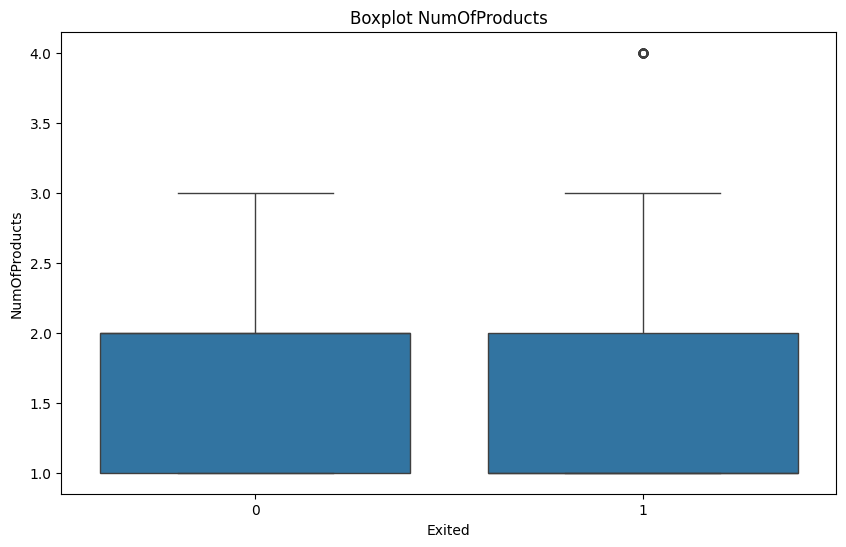

In [35]:
# CreditScore x Exit

plt.figure(figsize=(10,6))
sns.boxplot(y='NumOfProducts', x='Exited', data=df)
plt.title('Boxplot NumOfProducts')
plt.show()

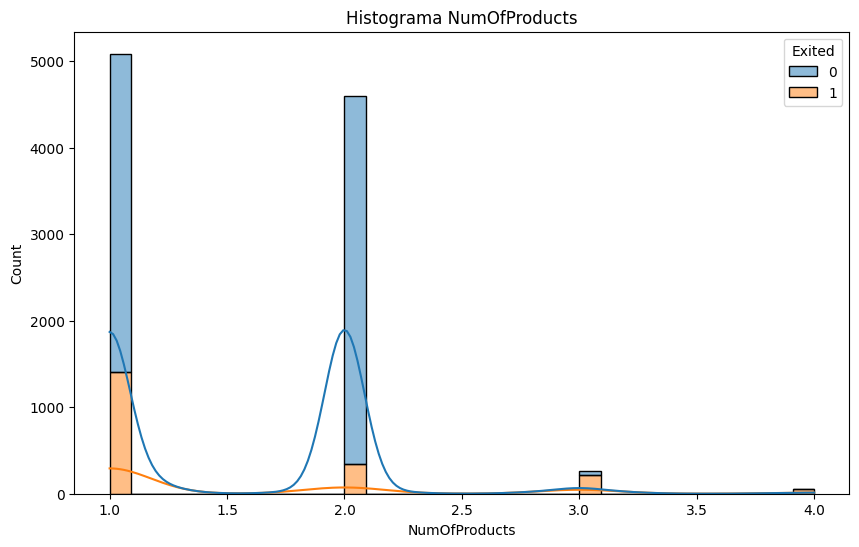

In [36]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='NumOfProducts', hue='Exited', kde=True, multiple='stack')
plt.title('Histograma NumOfProducts')
plt.show()

### HasCrCard	

Indica se o cliente possui ou não cartão de crédito do banco (1 para sim, 0 para não). Pode ser um indicador de engajamento com o banco.


In [37]:
df['HasCrCard'].value_counts()

HasCrCard
1    7055
0    2945
Name: count, dtype: int64

In [38]:
df[['HasCrCard','Exited']].groupby(['HasCrCard','Exited']).size().reset_index(name='Total')

,HasCrCard,Exited,Total
0,0,0,2332
1,0,1,613
2,1,0,5631
3,1,1,1424


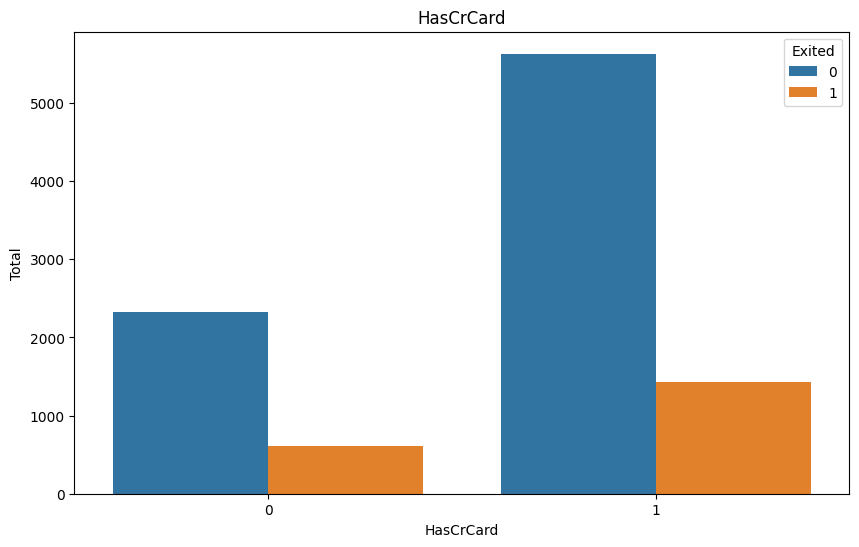

In [39]:
plt.figure(figsize=(10,6))
df_vc = df[['HasCrCard','Exited']].groupby(['HasCrCard','Exited']).size().reset_index(name='Total')
sns.barplot(x='HasCrCard', y='Total', hue='Exited', data=df_vc, orient='v')
plt.title('HasCrCard')
plt.show()

### IsActiveMember	

Indica se o cliente é considerado um membro ativo (1 para sim, 0 para não). A definição de "membro ativo" pode variar, mas geralmente se refere a clientes que realizam transações regularmente. Espera-se que membros inativos tenham maior propensão ao cancelamento da conta.

In [40]:
df['IsActiveMember'].value_counts()

IsActiveMember
1    5151
0    4849
Name: count, dtype: int64

In [41]:
df[['IsActiveMember','Exited']].groupby(['IsActiveMember','Exited']).size().reset_index(name='Total')

,IsActiveMember,Exited,Total
0,0,0,3547
1,0,1,1302
2,1,0,4416
3,1,1,735


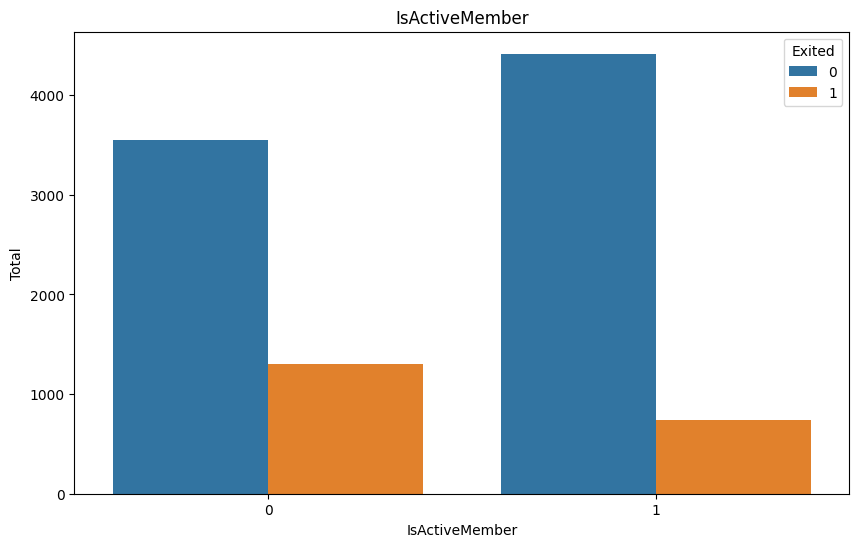

In [42]:
plt.figure(figsize=(10,6))
df_vc = df[['IsActiveMember','Exited']].groupby(['IsActiveMember','Exited']).size().reset_index(name='Total')
sns.barplot(x='IsActiveMember', y='Total', hue='Exited', data=df_vc, orient='v')
plt.title('IsActiveMember')
plt.show()

### EstimatedSalary

Salário estimado do cliente. Clientes com salários mais altos podem ser mais valiosos para o banco e ter menor probabilidade de cancelamento da conta.

In [43]:
df['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

In [44]:
df['EstimatedSalary'].value_counts()

EstimatedSalary
24924.92     2
140469.38    1
51695.41     1
151325.24    1
64327.26     1
            ..
2988.28      1
99595.67     1
53445.17     1
115146.40    1
23101.13     1
Name: count, Length: 9999, dtype: int64

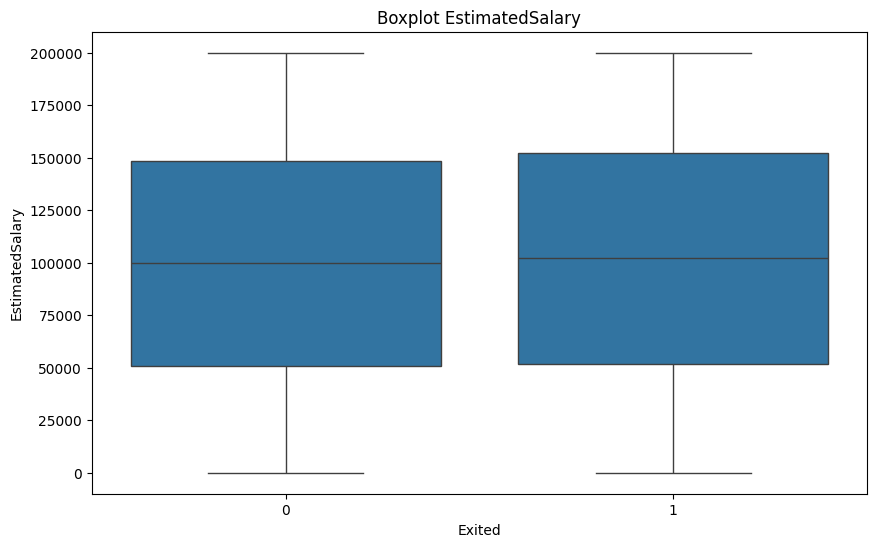

In [45]:
# CreditScore x Exit

plt.figure(figsize=(10,6))
sns.boxplot(y='EstimatedSalary', x='Exited', data=df)
plt.title('Boxplot EstimatedSalary')
plt.show()

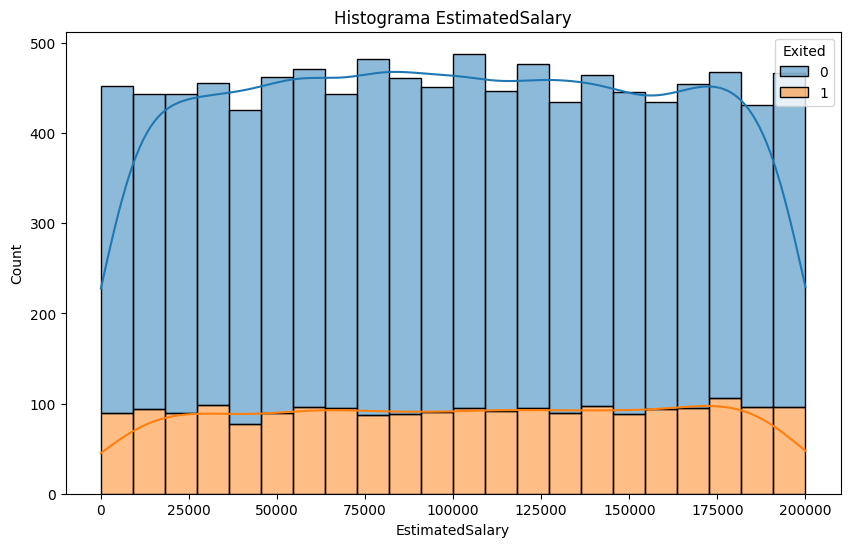

In [46]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='EstimatedSalary', hue='Exited', kde=True, multiple='stack')
plt.title('Histograma EstimatedSalary')
plt.show()

## Balanceamento de Classes

In [47]:
# transformar em dummies
df_model = pd.get_dummies(df, columns=['Geography','Gender'], drop_first=True).copy()

# transformar os valores booleanos em 0 e 1
df_model['Geography_Germany'] = df_model['Geography_Spain'].astype(int)
df_model['Geography_Spain'] = df_model['Geography_Germany'].astype(int)
df_model['Gender_Male'] = df_model['Gender_Male'].astype(int)


# Separar as variáveis independentes (X) e a variável dependente (y)
X = df_model.drop('Exited', axis=1)
y = df_model['Exited']


os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Exited'])

# we can Check the numbers of our data
print("Tamanho do oversampled é: ",len(os_data_X))
print("Número de não aderência:",len(os_data_y[os_data_y['Exited']==0]))
print("Número de aderência:",len(os_data_y[os_data_y['Exited']==1]))
print("Proporção de não aderência: ",len(os_data_y[os_data_y['Exited']==0])/len(os_data_X)*100, "%")
print("Proporção de aderência:", len(os_data_y[os_data_y['Exited']==1])/len(os_data_X)*100, "%")

X_train = os_data_X
y_train = os_data_y['Exited']

Tamanho do oversampled é:  11168
Número de não aderência: 5584
Número de aderência: 5584
Proporção de não aderência:  50.0 %
Proporção de aderência: 50.0 %


## Ausência de Multicolinearidade

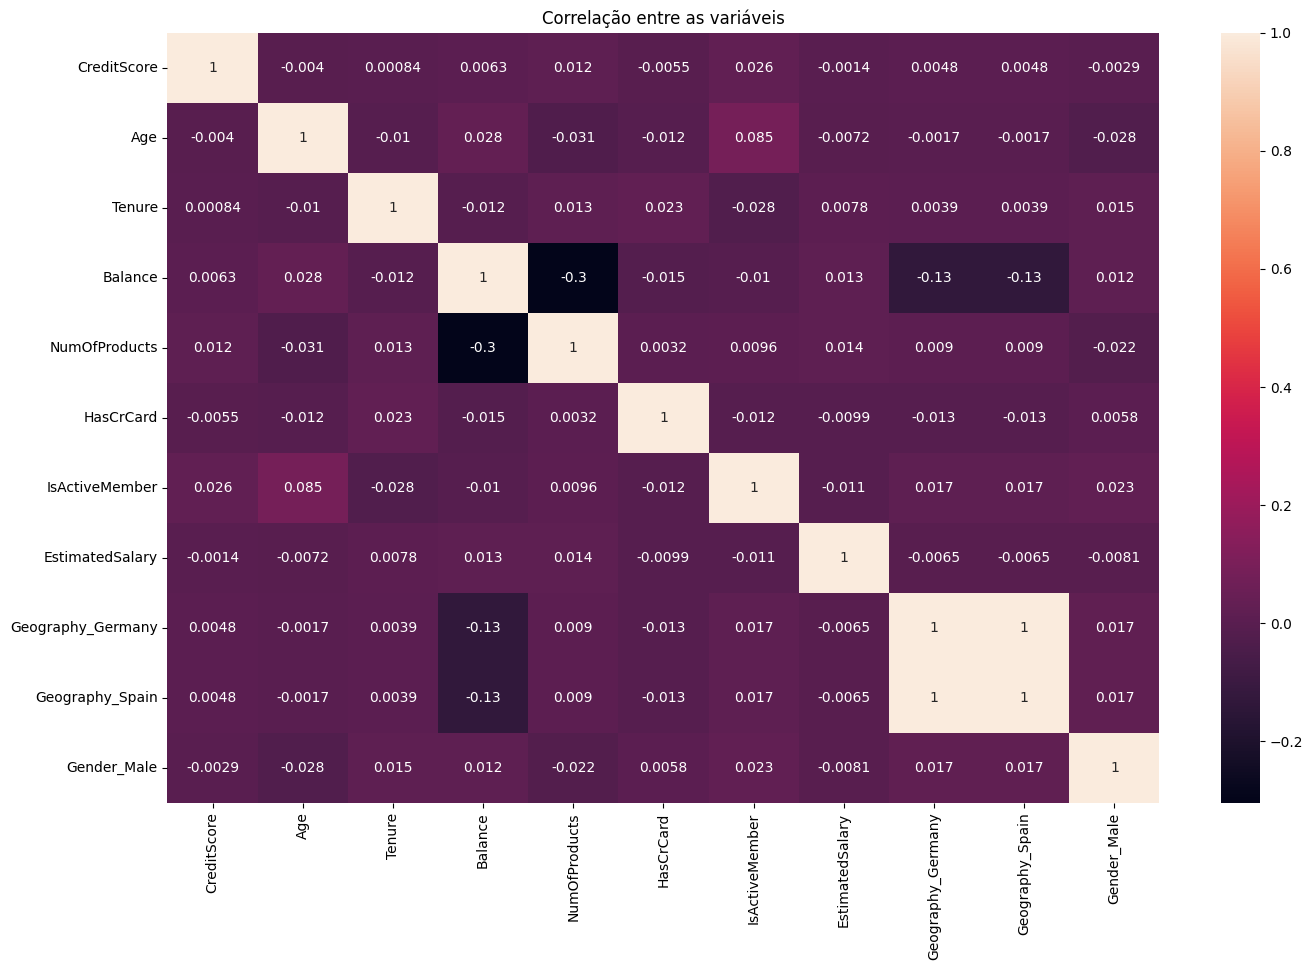

In [48]:
# correlação
corr = X.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True)
plt.title('Correlação entre as variáveis')
plt.show()

In [49]:
# Calcular o VIF para cada variável preditora
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,CreditScore,21.225314
1,Age,12.316351
2,Tenure,3.872753
3,Balance,2.668261
4,NumOfProducts,7.708766
5,HasCrCard,3.289273
6,IsActiveMember,2.075160
7,EstimatedSalary,3.887151
8,Geography_Germany,inf
9,Geography_Spain,inf


In [50]:
# Calcular o VIF para cada variável preditora
X_vif = X.drop(columns=['Geography_Spain'], errors='ignore')

scaler = MinMaxScaler()
X_vif = pd.DataFrame(scaler.fit_transform(X_vif), columns=X_vif.columns)

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
vif_data

,feature,VIF
0,CreditScore,7.189732
1,Age,4.333395
2,Tenure,3.608946
3,Balance,2.565843
4,NumOfProducts,1.897754
5,HasCrCard,3.099376
6,IsActiveMember,2.033913
7,EstimatedSalary,3.609303
8,Geography_Germany,1.329221
9,Gender_Male,2.111857


Para eliminar a multicolinearidade a variável Geography_Spain foi removida. 

CreditScore ainda possui um VIF um pouco alto mas será preservado.

Para garantir que o cálculo do VIF não seja afetado pela magnitude das variáveis, todas as variáveis foram padronizadas com MinMaxScaler(0 a 1).

In [51]:
cols = ['Geography_Spain']
df.drop(columns=cols, errors='ignore', inplace=True)
X.drop(columns=cols, errors='ignore', inplace=True)
X_train.drop(columns=cols, errors='ignore', inplace=True)
X_test.drop(columns=cols, errors='ignore', inplace=True)

## Modelo Logit

In [52]:
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.444947
         Iterations 6
                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: Exited           Pseudo R-squared: 0.120      
Date:               2025-01-10 18:31 AIC:              8918.9377  
No. Observations:   10000            BIC:              8991.0411  
Df Model:           9                Log-Likelihood:   -4449.5    
Df Residuals:       9990             LL-Null:          -5054.9    
Converged:          1.0000           LLR p-value:      5.5266e-255
No. Iterations:     6.0000           Scale:            1.0000     
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
CreditScore       -0.0036   0.0002 -19.0085 0.0000 -0.0039 -0.0032
Age                0.0589   0.0023  25.3560 0.0000  0

## Interpretação dos Coeficientes

In [53]:
coef = result.params
pval = result.pvalues
odds_ratio = np.exp(coef)
significance = pval.apply(lambda x: 'Significante' if x < 0.05 else 'Não Significante')

df_coef = pd.DataFrame({
    'Coeficiente': coef, 
    'Odds Ratio': odds_ratio, 
    'P-valor': pval, 
    'Significância': significance,
})
df_coef

,Coeficiente,Odds Ratio,P-valor,Significância
CreditScore,-3.571312e-03,0.996435,1.449177e-80,Significante
Age,5.885275e-02,1.060619,7.720996e-142,Significante
Tenure,-3.914622e-02,0.961610,1.366937e-05,Significante
Balance,3.204947e-06,1.000003,4.912917e-13,Significante
NumOfProducts,-2.698805e-01,0.763471,1.200851e-09,Significante
HasCrCard,-1.829269e-01,0.832829,1.160800e-03,Significante
IsActiveMember,-1.074303e+00,0.341536,5.556568e-82,Significante
EstimatedSalary,-8.388505e-07,0.999999,6.447896e-02,Não Significante
Geography_Germany,-3.062743e-01,0.736185,2.425679e-06,Significante
Gender_Male,-6.320580e-01,0.531497,5.507662e-33,Significante


In [54]:
md = f'''\
'''

for index, row in df_coef.iterrows():
    if index in ['Geography_Germany']:
        continue
    impactos = 'aumentam' if row['Coeficiente'] > 0 else 'diminuem'
    percentual = row['Odds Ratio'] - 1 if row['Coeficiente'] > 0 else 1 - row['Odds Ratio']
    tmp_md = \
        f'* __{index}__: Para cada aumento de 1 unidade, as chances de cancelamento de conta \
        {impactos} em cerca de {percentual:.8%} (multiplicadas por {row['Odds Ratio']:.8f}).'
    md += tmp_md + '\n'
    

md += f'''\
* __Geography_Germany__: Clientes da alemanha e Espanha tem 26.381535% (multiplicadas por 0.736185) menos chances de cancelamento de contas do que os clientes da França. Alemanha e Espanha possuem correlação perfeita, por essa razão, Espanha foi removida. França é a categoria base.
'''

display(Markdown(md))

* __CreditScore__: Para cada aumento de 1 unidade, as chances de cancelamento de conta         diminuem em cerca de 0.35649421% (multiplicadas por 0.99643506).
* __Age__: Para cada aumento de 1 unidade, as chances de cancelamento de conta         aumentam em cerca de 6.06190481% (multiplicadas por 1.06061905).
* __Tenure__: Para cada aumento de 1 unidade, as chances de cancelamento de conta         diminuem em cerca de 3.83899031% (multiplicadas por 0.96161010).
* __Balance__: Para cada aumento de 1 unidade, as chances de cancelamento de conta         aumentam em cerca de 0.00032050% (multiplicadas por 1.00000320).
* __NumOfProducts__: Para cada aumento de 1 unidade, as chances de cancelamento de conta         diminuem em cerca de 23.65292772% (multiplicadas por 0.76347072).
* __HasCrCard__: Para cada aumento de 1 unidade, as chances de cancelamento de conta         diminuem em cerca de 16.71709275% (multiplicadas por 0.83282907).
* __IsActiveMember__: Para cada aumento de 1 unidade, as chances de cancelamento de conta         diminuem em cerca de 65.84642160% (multiplicadas por 0.34153578).
* __EstimatedSalary__: Para cada aumento de 1 unidade, as chances de cancelamento de conta         diminuem em cerca de 0.00008389% (multiplicadas por 0.99999916).
* __Gender_Male__: Para cada aumento de 1 unidade, as chances de cancelamento de conta         diminuem em cerca de 46.85031554% (multiplicadas por 0.53149684).
* __Geography_Germany__: Clientes da alemanha e Espanha tem 26.381535% (multiplicadas por 0.736185) menos chances de cancelamento de contas do que os clientes da França. Alemanha e Espanha possuem correlação perfeita, por essa razão, Espanha foi removida. França é a categoria base.


## Importância das Variáveis

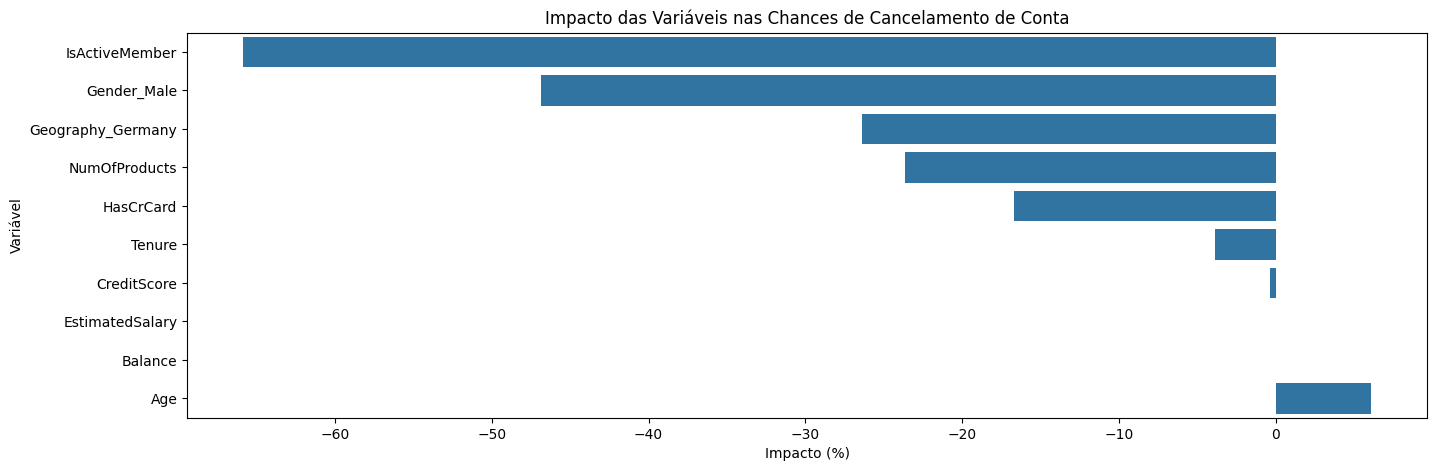

In [55]:
plt.figure(figsize=default_figsize)
sns.barplot(x=df_coef['Odds Ratio'].apply(lambda x: (x - 1) * 100).sort_values(), 
            y=df_coef['Odds Ratio'].apply(lambda x: (x - 1) * 100).sort_values().index, 
            orient='h')
plt.xlabel('Impacto (%)')
plt.ylabel('Variável')
plt.title('Impacto das Variáveis nas Chances de Cancelamento de Conta')
plt.show()

## Avaliação do Modelo

In [56]:
# Treinar o modelo com scikit-learn
model = LogisticRegression(random_state=42, max_iter=1000)

model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo com classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      2379
           1       0.39      0.59      0.47       621

    accuracy                           0.73      3000
   macro avg       0.64      0.68      0.64      3000
weighted avg       0.78      0.73      0.74      3000



In [57]:
conf_matrix = confusion_matrix(y_test, y_pred)
df_conf_mtx = pd.DataFrame(conf_matrix, columns=['Previsto 0', 'Previsto 1'], index=['Real 0', 'Real 1'])
df_conf_mtx.loc['Total Previsto'] = df_conf_mtx.sum(axis=0)
df_conf_mtx['Total Real'] = df_conf_mtx.sum(axis=1)
df_conf_mtx

,Previsto 0,Previsto 1,Total Real
Real 0,1812,567,2379
Real 1,253,368,621
Total Previsto,2065,935,3000


In [58]:
print(f'Acurácia Balanceada: {balanced_accuracy_score(y_test, y_pred):.2f}')
print(f'ROCAUC: {roc_auc_score(y_test, y_pred):.2f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')

Acurácia Balanceada: 0.68
ROCAUC: 0.68
F1 Score: 0.47


In [ ]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

plt.figure(figsize=(15,8))
plt.plot(fpr, tpr, label='Regressão Logística (área = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('CURVA ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

__Precision (Precisão):__

* Classe 0 (não encerramento de conta): 0.88 - Dos clientes previstos como "não encerramento de conta", 88% realmente não fizeram encerramento de conta.
* Classe 1 (encerramento de conta): 0.39 - Dos clientes previstos como "encerramento de conta", apenas 39% realmente fizeram encerramento de conta.

O modelo é bom em prever corretamente os clientes que não farão encerramento de conta, mas tem baixa precisão para prever os que farão encerramento de conta (muitos falsos positivos para encerramento de conta).


__Recall (Revocação ou Sensibilidade):__

* Classe 0 (não encerramento de conta): 0.76 - Dos clientes que realmente não fizeram encerramento de conta, o modelo previu corretamente 76%.
* Classe 1 (encerramento de conta): 0.59 - Dos clientes que realmente fizeram encerramento de conta, o modelo previu corretamente apenas 59%.

O modelo identifica uma boa parte dos clientes que realmente não farão encerramento de conta, mas tem uma taxa de detecção razoável para os clientes que realmente farão encerramento de conta (muitos falsos negativos para encerramento de conta).


__F1-Score:__

* Classe 0 (não encerramento de conta): 0.82 - Uma média harmônica entre precisão e recall para a classe 0.
* Classe 1 (encerramento de conta): 0.47 - Uma média harmônica entre precisão e recall para a classe 1.

O F1-Score é bom para a classe 0, mas baixo para a classe 1, refletindo o desequilíbrio entre precisão e recall para essa classe.
Accuracy (Acurácia): 0.73 - A proporção geral de previsões corretas (para ambas as classes). 73% das previsões do modelo estão corretas.


__Análise Geral:__

Baixa Precisão para encerramento de conta: A baixa precisão para a classe 1 (0.39) indica que o modelo gera muitos falsos positivos para encerramento de conta. Isso significa que o modelo frequentemente prevê que um cliente fará encerramento de conta quando, na verdade, ele não fará.

Recall Razoável para encerramento de conta: O recall razoável para a classe 1 (0.59) indica que o modelo identifica uma parte considerável dos clientes que realmente farão encerramento de conta, mas ainda perde uma quantidade significativa (falsos negativos).

Implicações para o Negócio: Dependendo do custo dos falsos positivos e falsos negativos, esse modelo pode não ser ideal. Se o custo de perder um cliente que fará encerramento de conta (falso negativo) for alto, o modelo precisará ser melhorado para aumentar o recall da classe 1. Se o custo de oferecer incentivos desnecessários a clientes que não fariam encerramento de conta (falso positivo) for alto, a precisão da classe 1 precisará ser melhorada.